In [22]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from pulp import LpProblem, LpMinimize, LpVariable, lpSum, LpBinary
import matplotlib.pyplot as plt

In [24]:

df = pd.read_csv(r"C:\Users\gudal\Downloads\ambulace optimization\extracted_data\final.csv")  # Replace with your actual file
accident_df = df.copy()
accident_coords = accident_df[["latitude", "longitude"]].values

In [25]:
def haversine_distance(coord1, coord2):
    lat1, lon1 = coord1
    lat2, lon2 = coord2
    R = 6371
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    d_phi = np.radians(lat2 - lat1)
    d_lambda = np.radians(lon2 - lon1)
    a = np.sin(d_phi / 2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(d_lambda / 2)**2
    return R * 2 * np.arcsin(np.sqrt(a))

In [26]:
def compute_travel_matrix(station_coords, accident_coords, speed_kmph=40):
    matrix = np.zeros((len(station_coords), len(accident_coords)))
    for i, s in enumerate(station_coords):
        for j, a in enumerate(accident_coords):
            dist = haversine_distance(s, a)
            matrix[i][j] = (dist / speed_kmph) * 60  # minutes
    return matrix

In [27]:
def select_ambulance_stations_kmeans(accident_coords, num_stations):
    kmeans = KMeans(n_clusters=num_stations, random_state=42)
    kmeans.fit(accident_coords)
    return kmeans.cluster_centers_

In [28]:
def optimize_ambulance_locations(travel_matrix, max_ambulances):
    n_stations, n_accidents = travel_matrix.shape
    model = LpProblem("Ambulance_Allocation", LpMinimize)

    x = [[LpVariable(f"x_{i}_{j}", cat=LpBinary) for j in range(n_accidents)] for i in range(n_stations)]
    y = [LpVariable(f"y_{i}", cat=LpBinary) for i in range(n_stations)]

    model += lpSum(travel_matrix[i][j] * x[i][j] for i in range(n_stations) for j in range(n_accidents))

    for j in range(n_accidents):
        model += lpSum(x[i][j] for i in range(n_stations)) == 1

    for i in range(n_stations):
        for j in range(n_accidents):
            model += x[i][j] <= y[i]

    model += lpSum(y) <= max_ambulances
    model.solve()

    assignments = {}
    for j in range(n_accidents):
        for i in range(n_stations):
            if x[i][j].varValue == 1:
                assignments[j] = (i, travel_matrix[i][j])
                break
    return assignments

In [29]:
def evaluate_assignments(assignments):
    times = [t[1] for t in assignments.values()]
    return {
        "Avg Travel Time (min)": np.mean(times),
        "Max Travel Time (min)": np.max(times),
        "Min Travel Time (min)": np.min(times)
    }

In [30]:
def simulate_rush_hour(travel_matrix, delay_factor=1.5):
    return travel_matrix * delay_factor

In [31]:
def simulate_accident_surge(accident_coords, factor=2):
    return np.vstack([accident_coords for _ in range(factor)])

In [45]:

fleet_sizes = [2, 3, 4, 5, 6]
results = []

for k in fleet_sizes:
    stations = select_ambulance_stations_kmeans(accident_coords, num_stations=k)
    travel_matrix = compute_travel_matrix(stations, accident_coords)
    assignments = optimize_ambulance_locations(travel_matrix, max_ambulances=k)
    metrics = evaluate_assignments(assignments)
    metrics["Fleet Size"] = k
    metrics["Scenario"] = "Base"
    results.append(metrics)

In [46]:
for k in fleet_sizes:
    stations = select_ambulance_stations_kmeans(accident_coords, num_stations=k)
    base_matrix = compute_travel_matrix(stations, accident_coords)
    delayed_matrix = simulate_rush_hour(base_matrix, delay_factor=1.5)
    assignments = optimize_ambulance_locations(delayed_matrix, max_ambulances=k)
    metrics = evaluate_assignments(assignments)
    metrics["Fleet Size"] = k
    metrics["Scenario"] = "Rush Hour"
    results.append(metrics)

In [47]:
accident_surge = simulate_accident_surge(accident_coords, factor=2)

for k in fleet_sizes:
    stations = select_ambulance_stations_kmeans(accident_surge, num_stations=k)
    travel_matrix = compute_travel_matrix(stations, accident_surge)
    assignments = optimize_ambulance_locations(travel_matrix, max_ambulances=k)
    metrics = evaluate_assignments(assignments)
    metrics["Fleet Size"] = k
    metrics["Scenario"] = "Accident Surge"
    results.append(metrics)

In [48]:
results_df = pd.DataFrame(results)
print(results_df)

    Avg Travel Time (min)  Max Travel Time (min)  Min Travel Time (min)  \
0               57.264651             190.539600               0.962495   
1               50.423955             191.358068               0.063729   
2               41.223873             139.068931               0.193337   
3               37.288583             138.038573               0.460455   
4               34.895379             116.488608               0.044713   
5               85.896977             285.809400               1.443742   
6               75.635933             287.037103               0.095593   
7               61.835809             208.603396               0.290005   
8               55.932874             207.057860               0.690683   
9               52.343069             174.732912               0.067069   
10              57.260925             190.554895               0.921323   
11              46.917248             155.795060               0.027280   
12              41.215093

In [60]:
# Combine all results into one DataFrame
all_results_df = pd.DataFrame(results)

# Group by scenario and summarize performance
summary = all_results_df.groupby("Scenario").agg({
    "Avg Travel Time (min)": ["mean", "min", "max"],
    "Max Travel Time (min)": "mean",
    "Min Travel Time (min)": "mean"
}).round(2)

# Save to CSV and print
summary.to_csv("scenario_summary.csv")
print(summary)


               Avg Travel Time (min)               Max Travel Time (min)  \
                                mean    min    max                  mean   
Scenario                                                                   
Accident Surge                 43.42  34.40  57.26                147.89   
Base                           44.22  34.90  57.26                155.10   
Rush Hour                      66.33  52.34  85.90                232.65   

               Min Travel Time (min)  
                                mean  
Scenario                              
Accident Surge                  0.44  
Base                            0.34  
Rush Hour                       0.52  


In [61]:
import folium

# Sample map centered around mean coordinates
center_lat = accident_df["latitude"].mean()
center_lon = accident_df["longitude"].mean()
m = folium.Map(location=[center_lat, center_lon], zoom_start=12)

# Add accident locations
for _, row in accident_df.iterrows():
    folium.CircleMarker(
        location=[row["latitude"], row["longitude"]],
        radius=3,
        color='red',
        fill=True,
        fill_opacity=0.6,
        tooltip="Accident"
    ).add_to(m)

# Add optimized ambulance stations (e.g., from `stations_kmeans`)
for lat, lon in stations_kmeans:
    folium.Marker(
        location=[lat, lon],
        icon=folium.Icon(color='blue', icon='plus'),
        tooltip="Ambulance Station"
    ).add_to(m)

m.save("ambulance_map.html")


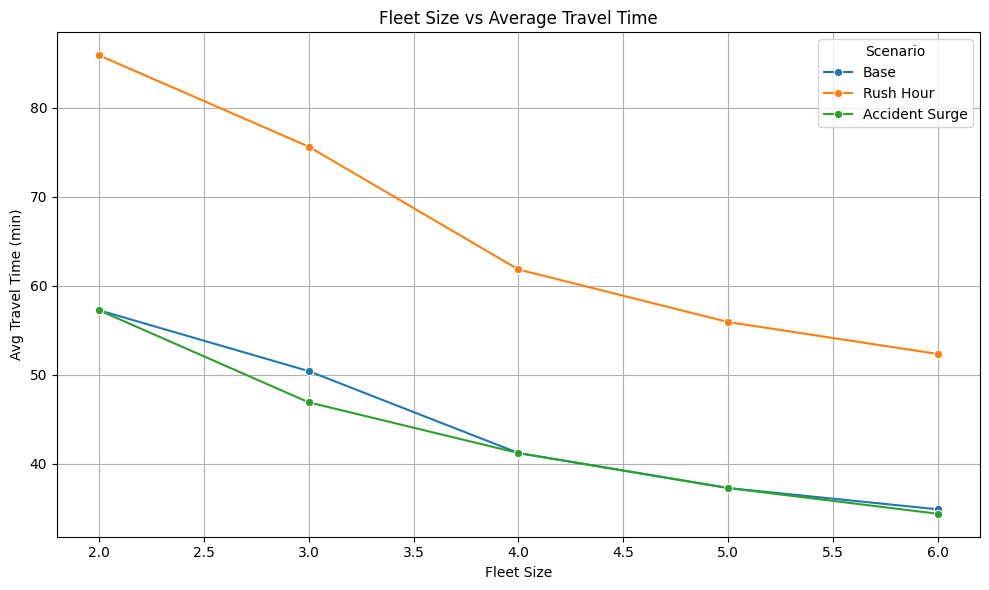

In [62]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.lineplot(data=all_results_df, x="Fleet Size", y="Avg Travel Time (min)", hue="Scenario", marker="o")
plt.title("Fleet Size vs Average Travel Time")
plt.ylabel("Avg Travel Time (min)")
plt.xlabel("Fleet Size")
plt.grid(True)
plt.tight_layout()
plt.savefig("fleet_vs_travel_time.png")
plt.show()
